### In this report version 1, I'm focusing on :
1. scraping
2. data munging
3. data cleaning
4. EDA

In [1]:

from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import json
import urllib
import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt
import urllib2
from datetime import datetime
%matplotlib inline

In [2]:
#url = "file:///Users/KerryChowChow/capstone/alton_messages.htm"

#I splitted the dataset into 12 subsets with ~5000lines each to make data processing faster.
# once build a pipeline, I can run the whole dataset.

url = "file:///Users/KerryChowChow/capstone/CAPSTONE/fb_message.htm"

request = urllib2.Request(url)
response = urllib2.urlopen(request)
html = response.read()
# requesting the urls and convert html to text file

In [3]:
time = Selector(text=html).xpath('//span[@class="meta"]/text()').extract()
message = Selector(text=html).xpath('//p').extract()
sender = Selector(text=html).xpath('//span[@class = "user"]/text()').extract()
thread = Selector(text=html).xpath('//div[@class = "thread"]').extract()


In [73]:
print len(message)
print len(sender)
print len(time)
print len(thread)
# check if they are in the same length

697577
697577
697577
8206


## adding thread into the dataframe

In [241]:
text_dict={
    "thread":[],
    "user_l":[],
    "message_l":[],
    "user": [],
    "message":[],
    "time":[]
    
}
for index,t in enumerate(thread):
    u = Selector(text=t).xpath('//span[@class = "user"]/text()').extract()
    m = Selector(text=t).xpath('//p').extract()
    time = Selector(text=t).xpath('//span[@class="meta"]/text()').extract()
    text_dict["thread"].append(index)
    text_dict["user_l"].append(len(u))
    text_dict["message_l"].append(len(m))
    text_dict['user'].append(u)
    text_dict['message'].append(m)
    text_dict['time'].append(time)


In [244]:
df_condense = pd.DataFrame({"thread": text_dict["thread"], "user": text_dict['user'], "message": text_dict['message'], "length": text_dict["message_l"], "time": text_dict["time"]})

In [245]:
df_condense.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8206 entries, 0 to 8205
Data columns (total 5 columns):
length     8206 non-null int64
message    8206 non-null object
thread     8206 non-null int64
time       8206 non-null object
user       8206 non-null object
dtypes: int64(2), object(3)
memory usage: 320.6+ KB


In [ ]:
df_condense.tail()

In [248]:
df_3 = df_condense.copy()

In [249]:
df_3_u = pd.concat([pd.DataFrame(v, index=np.repeat(k,len(v))) 
            for k,v in df_3.user.to_dict().items()])
df_3_u.reset_index(inplace=True)

In [253]:
df_3_m = pd.concat([pd.DataFrame(v, index=np.repeat(k,len(v))) 
            for k,v in df_3.message.to_dict().items()])
df_3_m.reset_index(inplace=True)

In [254]:
df_3_t = pd.concat([pd.DataFrame(v, index=np.repeat(k,len(v))) 
            for k,v in df_3.time.to_dict().items()])
df_3_t.reset_index(inplace=True)

In [255]:
df_join = pd.concat([df_3_u, df_3_m, df_3_t], axis = 1)

In [257]:
df_join.columns

Index([u'index', 0, u'index', 0, u'index', 0], dtype='object')

In [260]:
df_join.columns = ['thread#', 'user','delete','message', "delete2", "time"]

In [263]:
df_join.drop(['delete', "delete2"], axis = 1, inplace = True)

In [99]:
#df_3.user = df_3.user.map(str)

In [266]:
df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697577 entries, 0 to 697576
Data columns (total 4 columns):
thread#    697577 non-null int64
user       697577 non-null object
message    697577 non-null object
time       697577 non-null object
dtypes: int64(1), object(3)
memory usage: 21.3+ MB


## forming dataframe and cleaning

In [357]:
just_in_case_df = df_join.copy()

In [275]:
#df = pd.DataFrame({"sender":sender,"time": time, "message": message })
text_df = df_join.copy()
#turn into a dataframe

In [276]:
#clean text column, removing element tag
import re

text_df["message"] = text_df["message"].map(lambda x: re.findall(r'<p>([\s\S]*?)</p>', x)[0])

In [277]:
#changing sender names
text_df["user"] = text_df["user"].map(lambda x: "Main_User" if x == "I am the name of the sender" else x)
text_df.head(2)

,thread#,user,message,time
0,0,Main_User,http://www.scoutzie.com/,"Friday, February 17, 2012 at 4:54pm PST"
1,0,Main_User,how'd you find it?,"Friday, February 17, 2012 at 4:53pm PST"


In [278]:
# creating a dictionary of user names and match them with a number

friends_dict = {}
reverse_friends_dict = {}

index = 1

for u in text_df['user'].unique():
    if '@facebook.com' not in u and 'Main_User' not in u:
        #print index ,u
        friends_dict["Person_"+str(index)] = u
        reverse_friends_dict[u] = "Person_"+str(index)
        index +=1



In [280]:
text_df.head()

,thread#,user,message,time
0,0,Main_User,http://www.scoutzie.com/,"Friday, February 17, 2012 at 4:54pm PST"
1,0,Main_User,how'd you find it?,"Friday, February 17, 2012 at 4:53pm PST"
2,0,Main_User,I'd look up their ip traceback etcetc thing an...,"Friday, February 17, 2012 at 4:53pm PST"
3,0,Main_User,Know who is behind it?,"Friday, February 17, 2012 at 4:53pm PST"
4,0,Main_User,"Whatever it is, it looks exclusive in their tw...","Friday, February 17, 2012 at 4:52pm PST"


In [281]:
# matching the sender column's senders back to the sudo name created at the friends dictionary

text_df['user'] = text_df['user'].map(lambda x: reverse_friends_dict[x] if x in reverse_friends_dict.keys() else x)

In [282]:
#changing main user's name inside a text to Main_User
replaced_word = re.compile('I am sender')
text_df.message = text_df.message.map(lambda x: replaced_word.sub('Main_User', x))

In [283]:
text_df.head()

,thread#,user,message,time
0,0,Main_User,http://www.scoutzie.com/,"Friday, February 17, 2012 at 4:54pm PST"
1,0,Main_User,how'd you find it?,"Friday, February 17, 2012 at 4:53pm PST"
2,0,Main_User,I'd look up their ip traceback etcetc thing an...,"Friday, February 17, 2012 at 4:53pm PST"
3,0,Main_User,Know who is behind it?,"Friday, February 17, 2012 at 4:53pm PST"
4,0,Main_User,"Whatever it is, it looks exclusive in their tw...","Friday, February 17, 2012 at 4:52pm PST"


In [284]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697577 entries, 0 to 697576
Data columns (total 4 columns):
thread#    697577 non-null int64
user       697577 non-null object
message    697577 non-null object
time       697577 non-null object
dtypes: int64(1), object(3)
memory usage: 21.3+ MB


In [286]:
#getting rid of time zone. ONLY PRESS ONCE!!
text_df.time = text_df.time.map(lambda x: x[:-3])

In [287]:
text_df.head()

,thread#,user,message,time
0,0,Main_User,http://www.scoutzie.com/,"Friday, February 17, 2012 at 4:54pm"
1,0,Main_User,how'd you find it?,"Friday, February 17, 2012 at 4:53pm"
2,0,Main_User,I'd look up their ip traceback etcetc thing an...,"Friday, February 17, 2012 at 4:53pm"
3,0,Main_User,Know who is behind it?,"Friday, February 17, 2012 at 4:53pm"
4,0,Main_User,"Whatever it is, it looks exclusive in their tw...","Friday, February 17, 2012 at 4:52pm"


In [288]:
#converting the time column from unicode to string 
text_df.time = text_df.time.map(lambda x: x.encode('ascii','ignore'))

In [289]:
text_df.time = text_df.time.map(lambda x: datetime.strptime(x, '%A, %B %d, %Y at %I:%M%p '))

In [15]:
print len(message)
print len(sender)
print len(time)
print len(thread)
# next challenge: creating a thread column

697577
697577
697577
8206


In [290]:
text_df.tail()
# a total of 697,576 messages exchanged with 1902 different people who are still facebook friends

,thread#,user,message,time
697572,8205,Main_User,but you've gotta start the other way around,2011-10-09 23:15:00
697573,8205,Main_User,"Ah, that's a good way to make friends out of e...",2011-10-09 23:15:00
697574,8205,Person_1902,like i call everyone out on their bullshit,2011-10-09 23:15:00
697575,8205,Person_1902,because I call her out on her bullshit,2011-10-09 23:15:00
697576,8205,Main_User,I see,2011-10-09 23:15:00


## Time series on the whole dataset

In [938]:
# before pressing, change the df name
whole_df = text_df.copy()
whole_df.set_index('time', inplace=True)
whole_df['Year'] = whole_df.index.year
whole_df['Month'] = whole_df.index.month

In [437]:
whole_df.tail()

,thread#,user,message,Year,Month
time,,,,,
2011-10-09 23:15:00,8205,Main_User,but you've gotta start the other way around,2011,10
2011-10-09 23:15:00,8205,Main_User,"Ah, that's a good way to make friends out of e...",2011,10
2011-10-09 23:15:00,8205,Person_1902,like i call everyone out on their bullshit,2011,10
2011-10-09 23:15:00,8205,Person_1902,because I call her out on her bullshit,2011,10
2011-10-09 23:15:00,8205,Main_User,I see,2011,10


## Look at number of messages exchanged then number of words exchanged through the years

In [44]:
plt.style.use('fivethirtyeight')

# Basically, the HD version
%config InlineBackend.figure_format = 'retina'

# Create a figure size
fig = plt.figure(figsize=(13,8))


In [303]:
whole_df.index.sort_values(ascending = False)
#messages were recorded from 1970 to 2016

DatetimeIndex(['2016-10-27 03:27:00', '2016-10-27 03:26:00',
               '2016-10-27 03:25:00', '2016-10-27 03:25:00',
               '2016-10-27 03:25:00', '2016-10-27 03:25:00',
               '2016-10-27 03:25:00', '2016-10-27 03:25:00',
               '2016-10-27 03:24:00', '2016-10-27 03:24:00',
               ...
               '1970-05-31 07:58:00', '1970-05-31 07:57:00',
               '1970-05-31 07:57:00', '1970-05-31 07:53:00',
               '1970-05-31 07:53:00', '1970-05-31 07:53:00',
               '1970-05-31 07:53:00', '1970-05-31 07:52:00',
               '1970-05-31 07:52:00', '1970-05-22 05:38:00'],
              dtype='datetime64[ns]', name=u'time', length=697577, freq=None)

In [307]:
whole_df.Year.unique()
# the real time frame should be from 2006 to 2016. 10 years of conversations.

array([2012, 2011, 2010, 2009, 2008, 2007, 2016, 2013, 2015, 2014, 2006,
       1970])

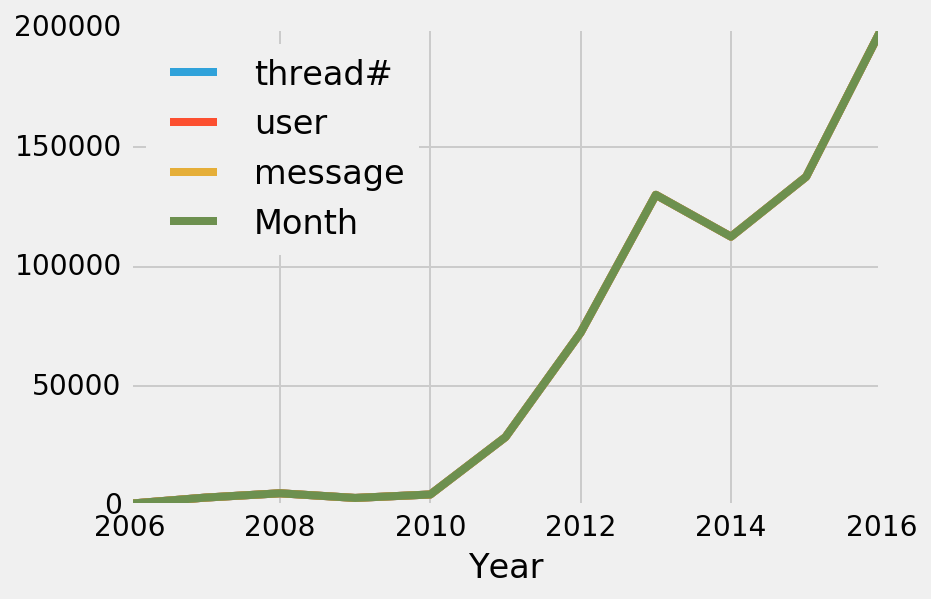

In [321]:

whole_df[whole_df.Year > 1970].groupby(['Year']).count().plot()

In [351]:
#mask_1 = ((whole_df['Year']==1970) | (whole_df['Year']==2006))
#temp_df = whole_df[mask_1]
#temp_df
whole_df.groupby(['Year']).count()
# there are 37 messages happening in 1970?!

,thread#,user,message,Month
Year,,,,
1970,37,37,37,37
2006,796,796,796,796
2007,3333,3333,3333,3333
2008,5155,5155,5155,5155
2009,3208,3208,3208,3208
2010,4653,4653,4653,4653
2011,28661,28661,28661,28661
2012,72383,72383,72383,72383
2013,130014,130014,130014,130014


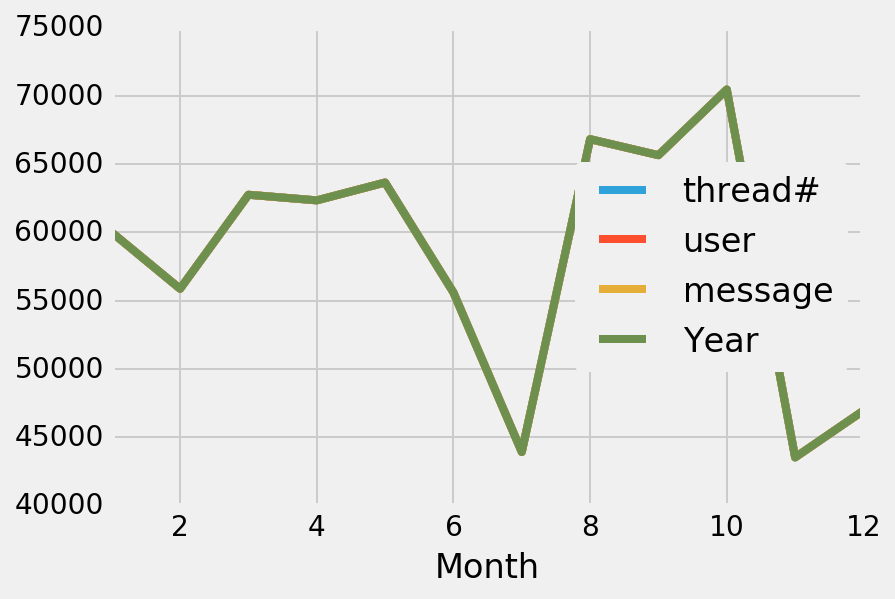

In [439]:
whole_df.groupby(['Month']).count().plot()
# which can be

In [325]:
whole_df[whole_df.Year == 1970][-5:]
# seems like this bug comes from thread# 4591 and thread#6654


,thread#,user,message,Year,Month
time,,,,,
1970-05-31 07:53:00,4591,Main_User,Maybe our life,1970,5
1970-05-31 07:53:00,4591,Main_User,This is your life,1970,5
1970-05-31 07:52:00,4591,Main_User,It's all up to you.,1970,5
1970-05-31 07:52:00,4591,Main_User,"Ok, if that is your choice.",1970,5
1970-05-22 05:38:00,6654,Person_1833,Tomorrow you mean?,1970,5


## Fixing bugs where some messages was dated in 1970

In [338]:
text_df[text_df['thread#'] == 4591].time.apply(lambda x: x.year).unique()
#seems like it's safe to move the 1970 ones to 2012

array([2012, 1970])

In [392]:
text_df[text_df['thread#'] == 6654].time.apply(lambda x: x.year).unique()
# only one message dated in 1970. Going to just drop that row.

array([2014, 2013])

In [393]:
text_df[text_df['thread#'] == 4591].time.apply(lambda x: x.month).unique()


array([12, 11, 10,  5])

In [424]:

def change_year(x):
    if x.year == 1970:
        x = x.replace(year=2012)
        return x
    else:
        return x

#d1.replace(year=2009)



In [433]:
text_df[text_df['thread#'] == 4591].time.apply(lambda x: x.year).unique()

array([2012])

In [341]:
text_df.drop(556017, axis =0, inplace = True)
#DON'T PRESS ME AGAIN

In [552]:
whole_df.groupby(['Year']).count().message

Year
2006       796
2007      3333
2008      5155
2009      3208
2010      4653
2011     28661
2012     72419
2013    130014
2014    112502
2015    137563
2016    199272
Name: message, dtype: int64

In [443]:
whole_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 697576 entries, 2012-02-17 16:54:00 to 2011-10-09 23:15:00
Data columns (total 5 columns):
thread#    697576 non-null int64
user       697576 non-null object
message    697576 non-null object
Year       697576 non-null int32
Month      697576 non-null int32
dtypes: int32(2), int64(1), object(2)
memory usage: 26.6+ MB


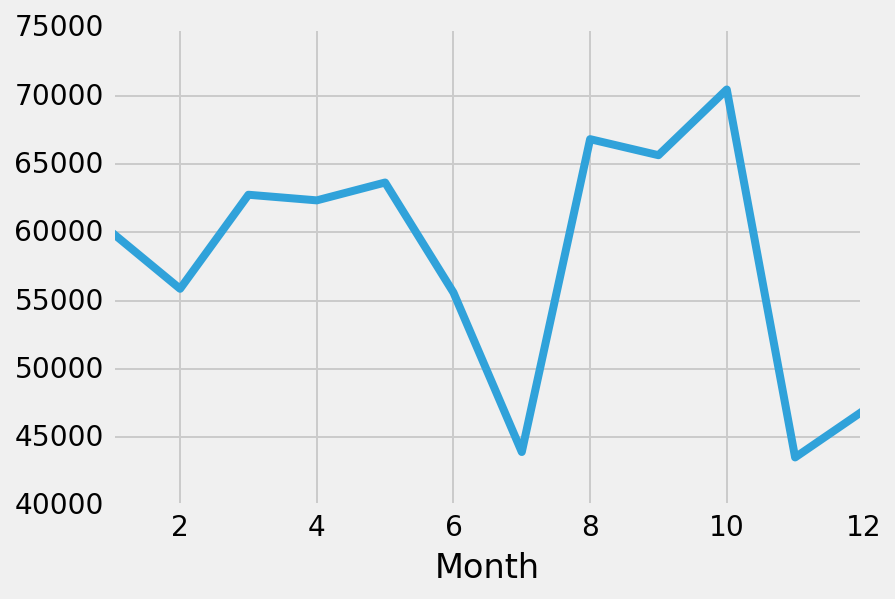

In [449]:
whole_df.groupby(['Month']).count().message.plot()

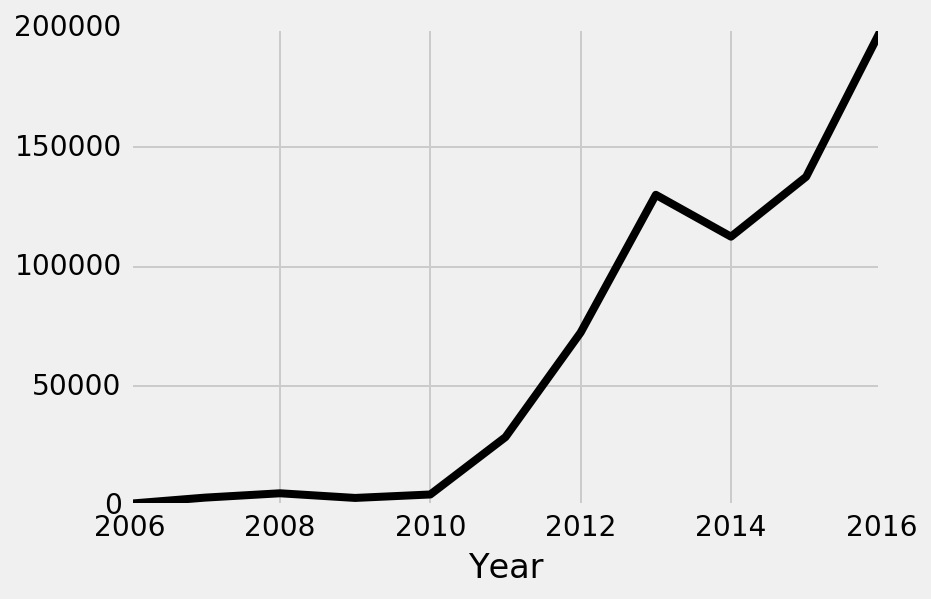

In [471]:
whole_df.groupby(['Year']).count().message.plot(color = 'k')

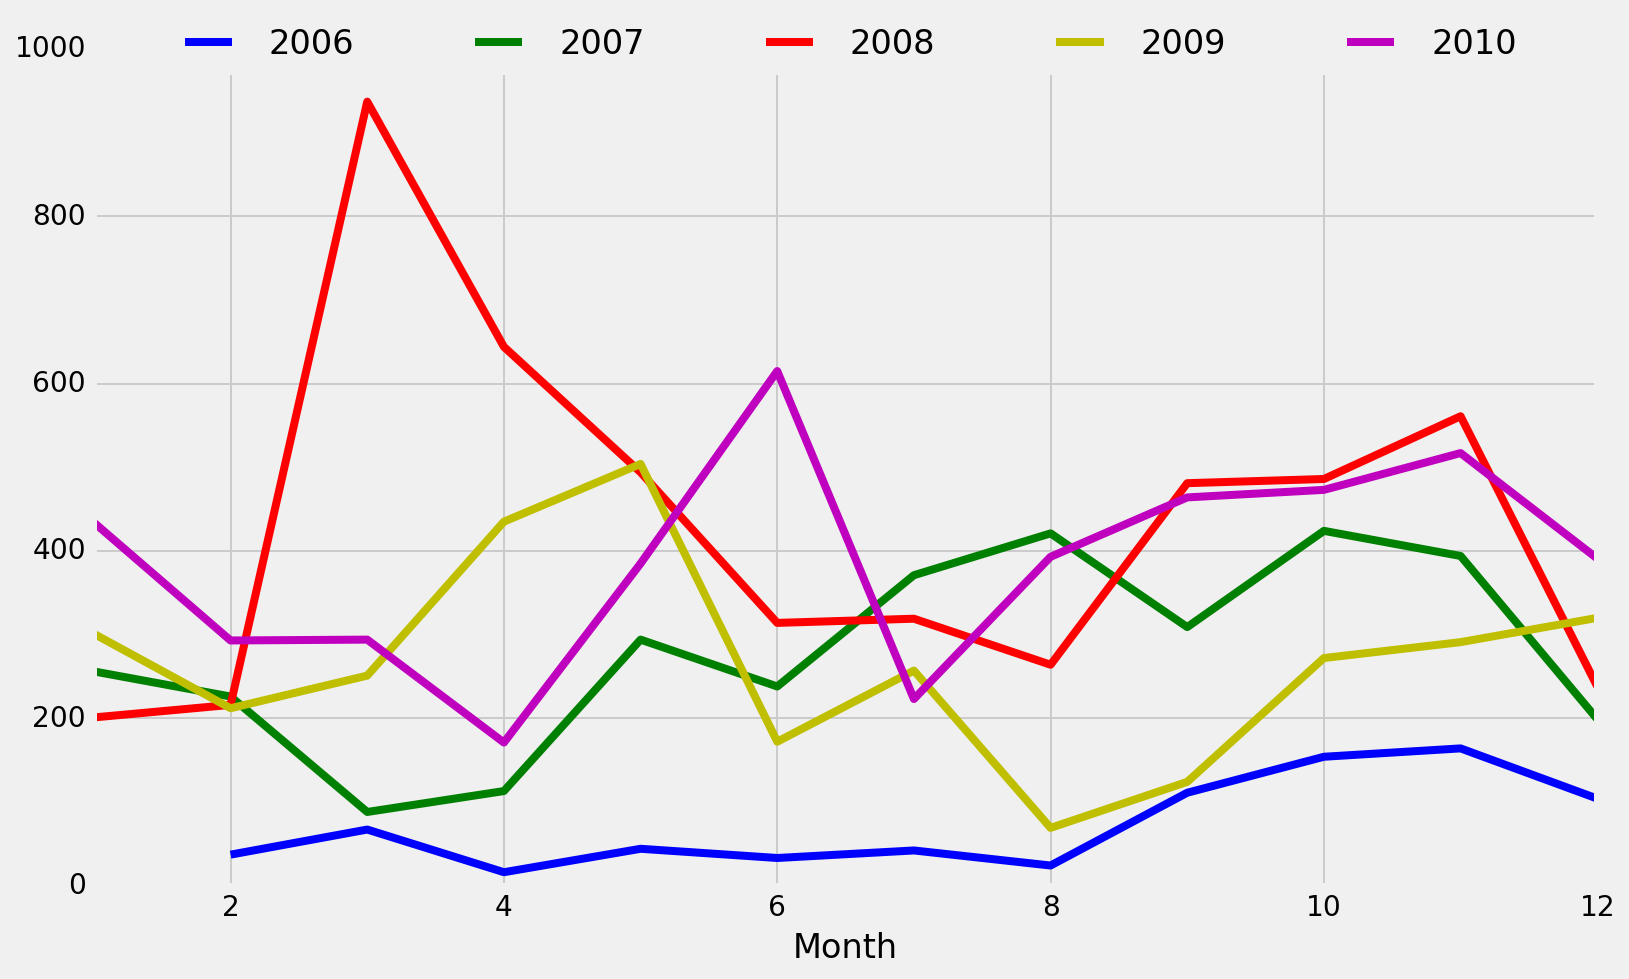

In [779]:
# comparing the #messages each month by years
plt.figure(figsize=(12,7))
whole_df[whole_df.Year == 2006].groupby(['Month']).count().message.plot(color = 'b')
whole_df[whole_df.Year == 2007].groupby(['Month']).count().message.plot(color = 'g')
whole_df[whole_df.Year == 2008].groupby(['Month']).count().message.plot(color = 'r')
whole_df[whole_df.Year == 2009].groupby(['Month']).count().message.plot(color = 'y')
whole_df[whole_df.Year == 2010].groupby(['Month']).count().message.plot(color = 'm')

plt.legend(['2006', '2007', '2008', '2009', '2010'], 
          bbox_to_anchor = (0., 1.02, 1., .102), loc=1,
          ncol=6, borderaxespad=2, mode="expand")

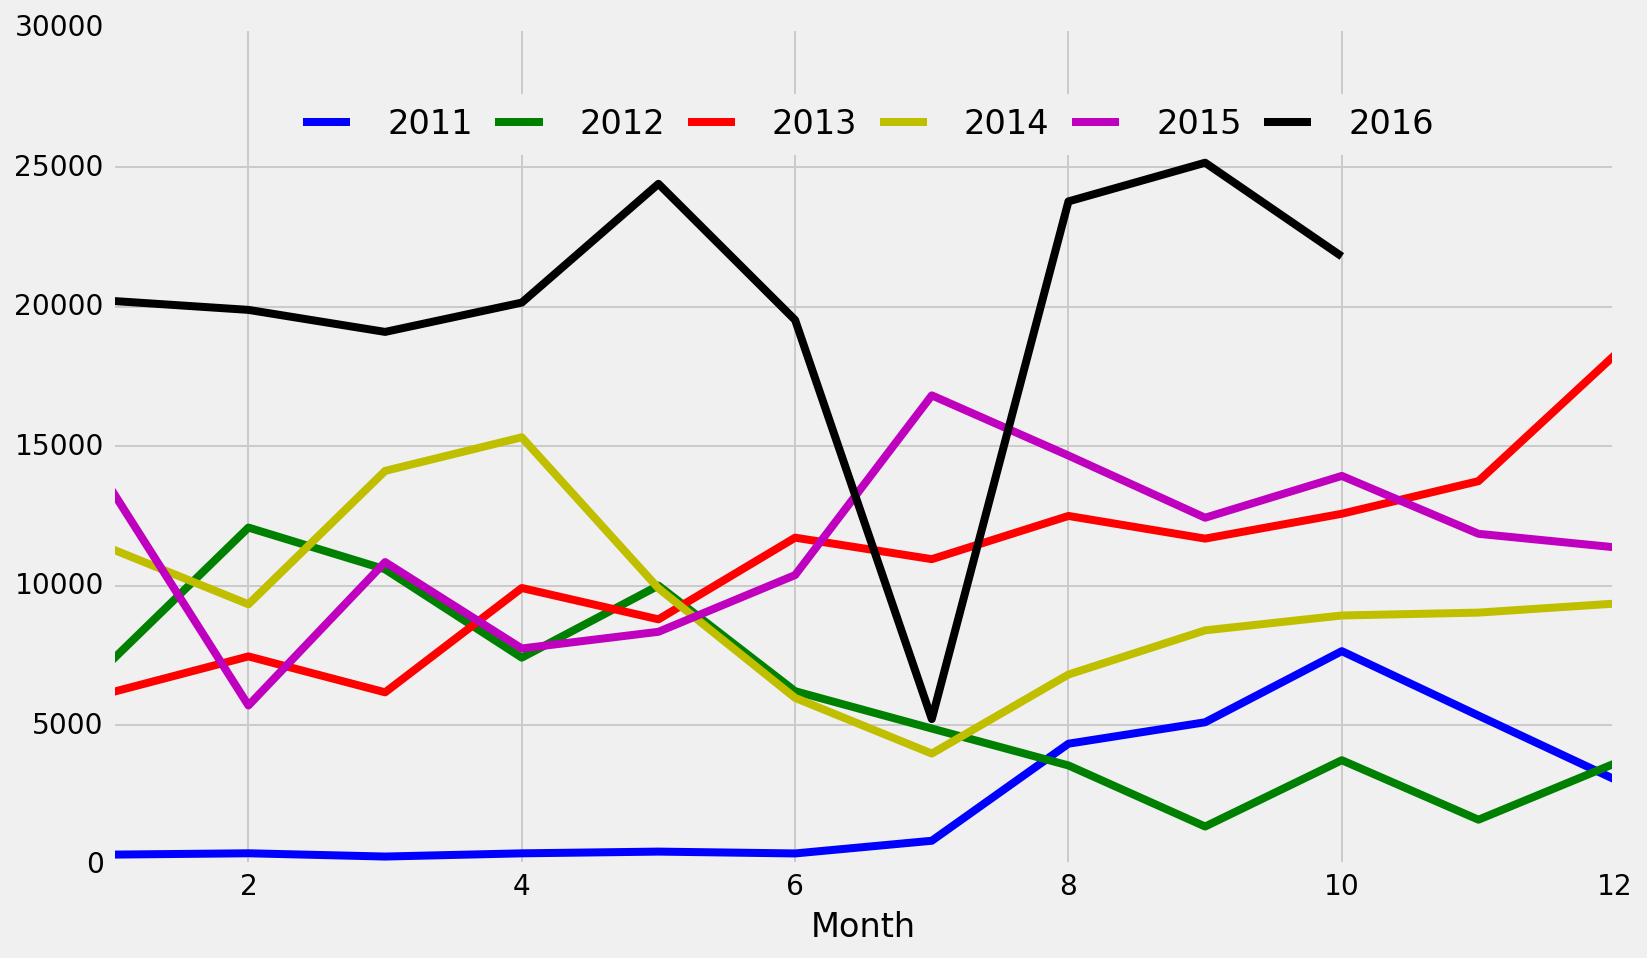

In [780]:
plt.figure(figsize=(12,7))
whole_df[whole_df.Year == 2011].groupby(['Month']).count().message.plot(color = 'b', label = '2011')
whole_df[whole_df.Year == 2012].groupby(['Month']).count().message.plot(color = 'g', label = '2012')
whole_df[whole_df.Year == 2013].groupby(['Month']).count().message.plot(color = 'r', label = '2013')
whole_df[whole_df.Year == 2014].groupby(['Month']).count().message.plot(color = 'y', label = '2014')
whole_df[whole_df.Year == 2015].groupby(['Month']).count().message.plot(color = 'm', label = '2015')
whole_df[whole_df.Year == 2016].groupby(['Month']).count().message.plot(color = 'k', label = '2016')
plt.legend(['2011', '2012', '2013', '2014', '2015', '2016'], 
          bbox_to_anchor = (0., 1.02, 1., .102), loc=1,
          ncol=6, borderaxespad=5, mode="expand")
#bbox_to_anchor=(0., 1.02, 1., .102), ncol=6, borderaxespad=3, mode="expand"
#(x, y, width, height of the bbox)

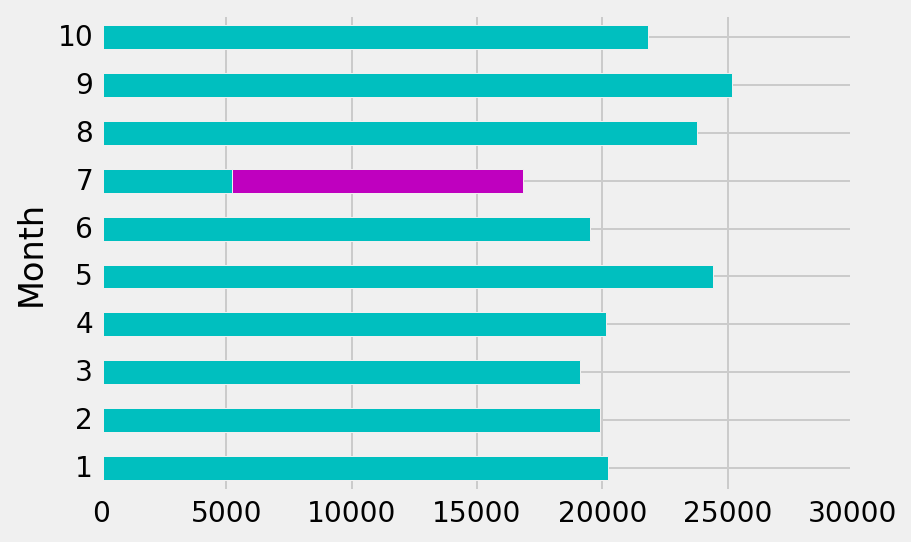

In [506]:
whole_df[whole_df.Year == 2014].groupby(['Month']).count().message.plot(color = 'y',kind = 'barh', stacked = False)
whole_df[whole_df.Year == 2015].groupby(['Month']).count().message.plot(color = 'm',kind = 'barh',stacked = False)
whole_df[whole_df.Year == 2016].groupby(['Month']).count().message.plot(color = 'c',kind= 'barh',stacked = False)
#links to look into to make a btter stacked bar: 
#http://seaborn.pydata.org/examples/horizontal_barplot.html
#http://randyzwitch.com/creating-stacked-bar-chart-seaborn/
#http://chrisalbon.com/python/matplotlib_stacked_bar_plot.html

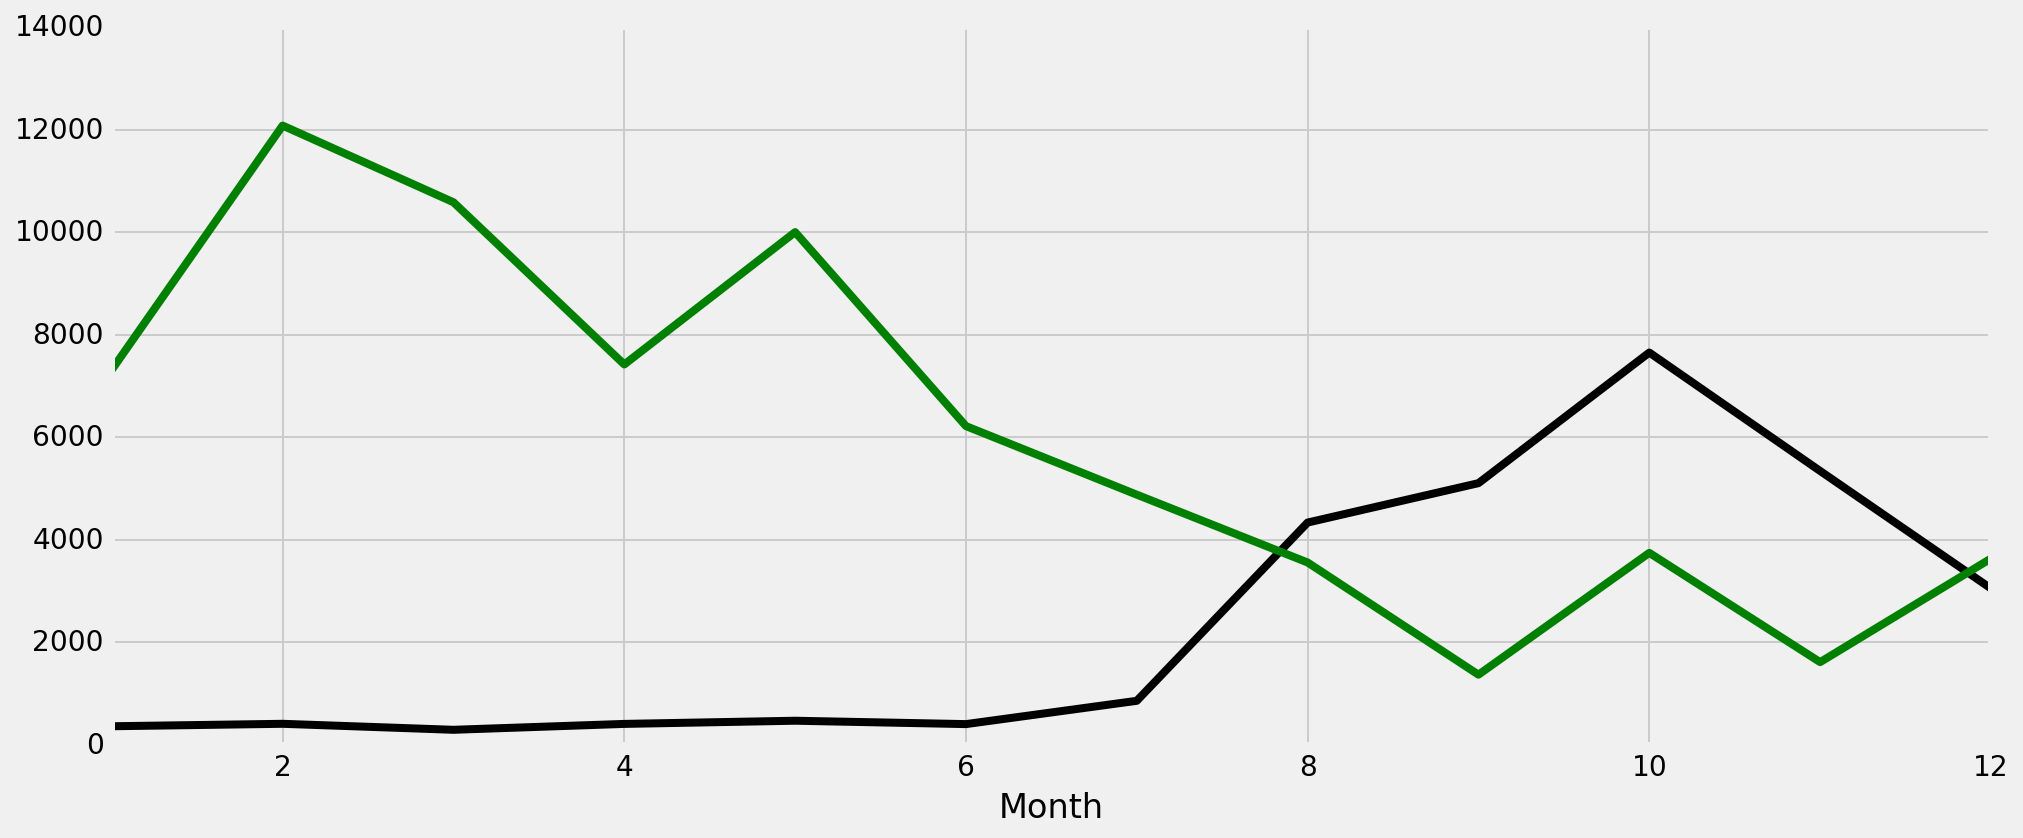

In [572]:
plt.figure(figsize=(15,6))

whole_df[whole_df.Year == 2011].groupby(['Month']).count().message.plot(color = 'k')
whole_df[whole_df.Year == 2012].groupby(['Month']).count().message.plot(color = 'g')

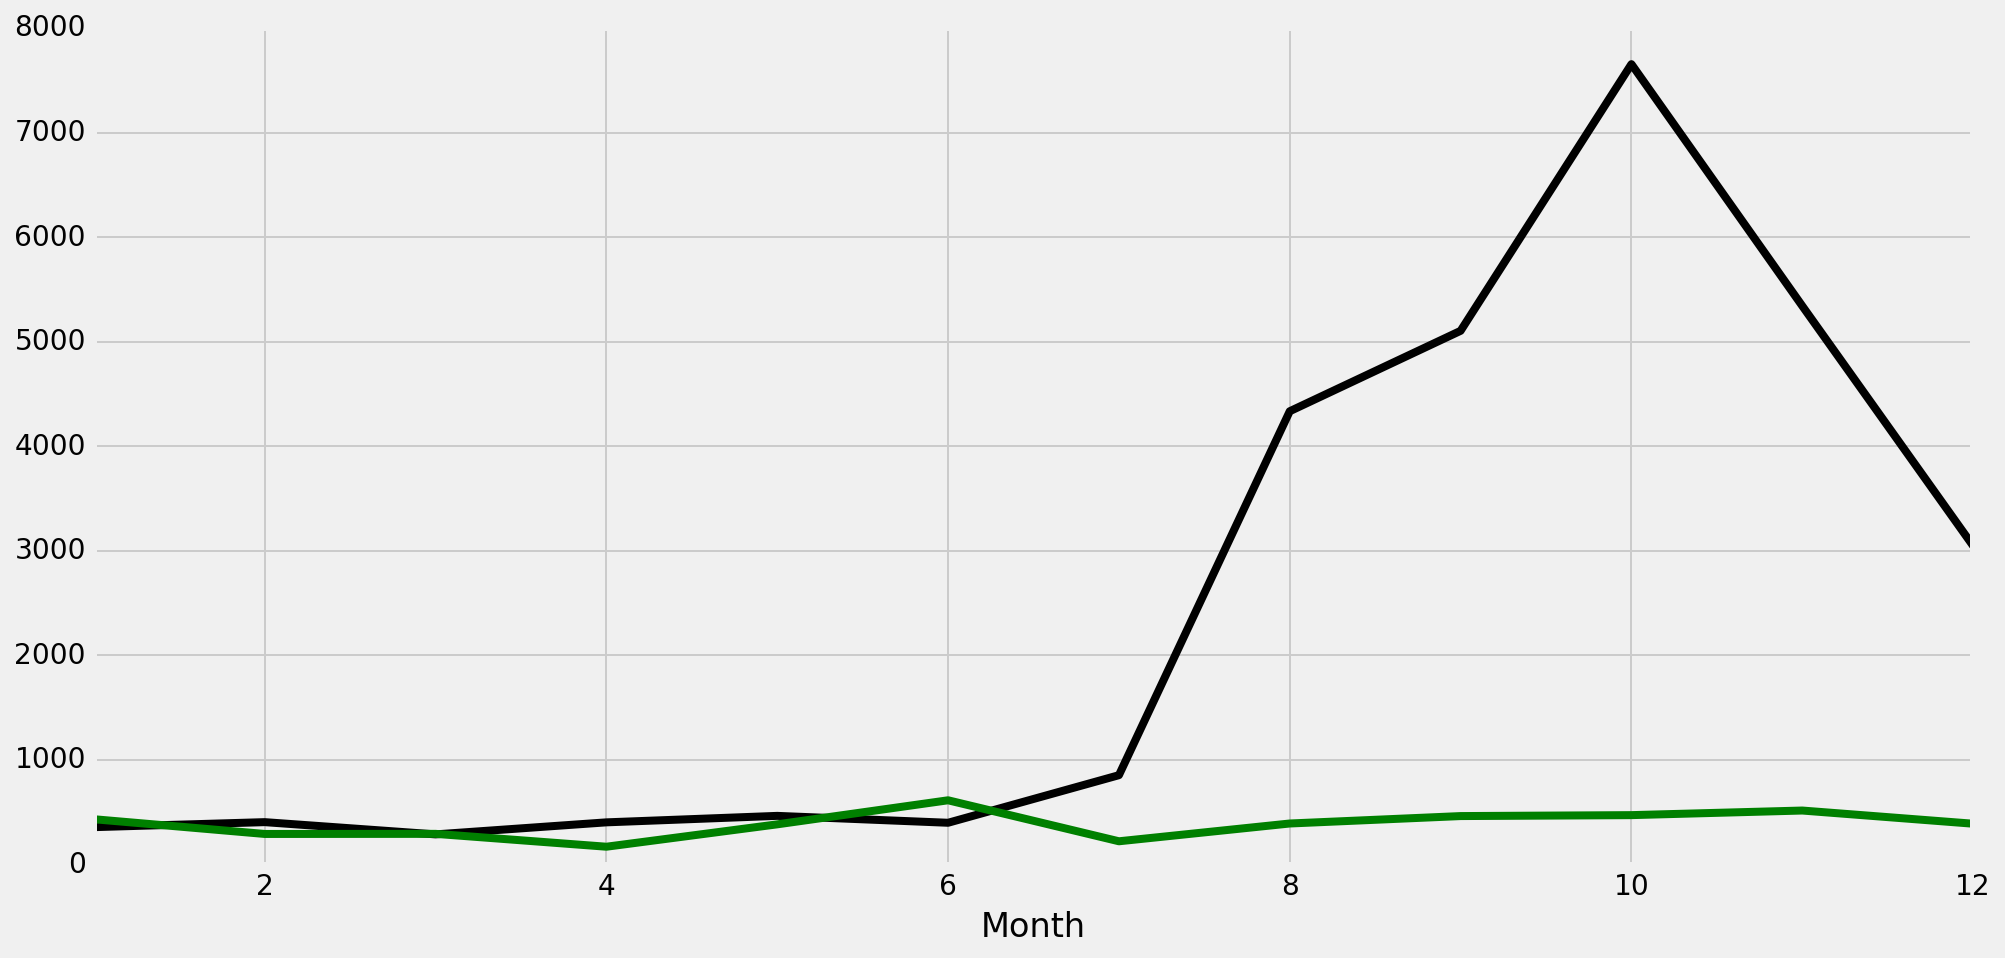

In [571]:
plt.figure(figsize=(15,7))
whole_df[whole_df.Year == 2011].groupby(['Month']).count().message.plot(color = 'k')#
whole_df[whole_df.Year == 2010].groupby(['Month']).count().message.plot(color = 'g')

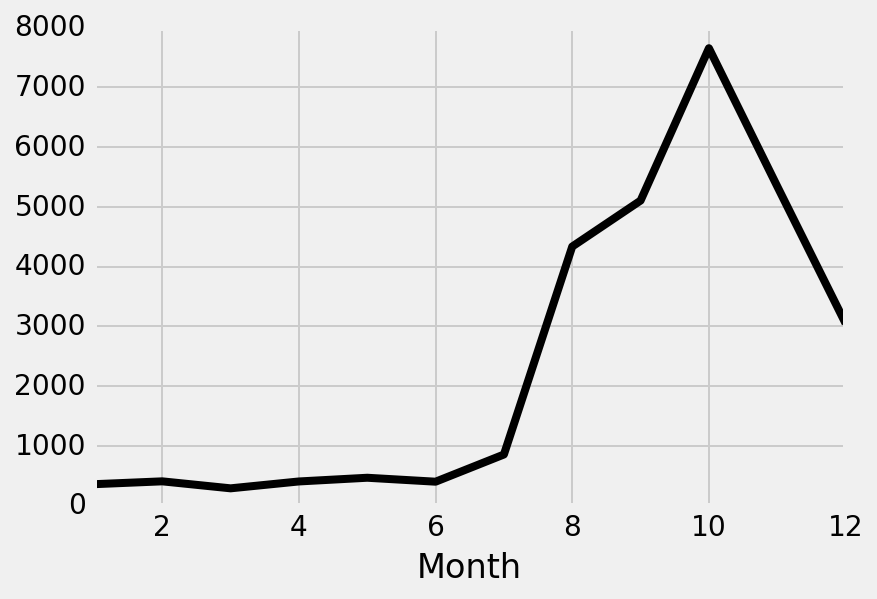

In [573]:
whole_df[whole_df.Year == 2011].groupby(['Month']).count().message.plot(color = 'k')

In [939]:
#looking at hours
whole_df["Hour"] = whole_df.index.hour

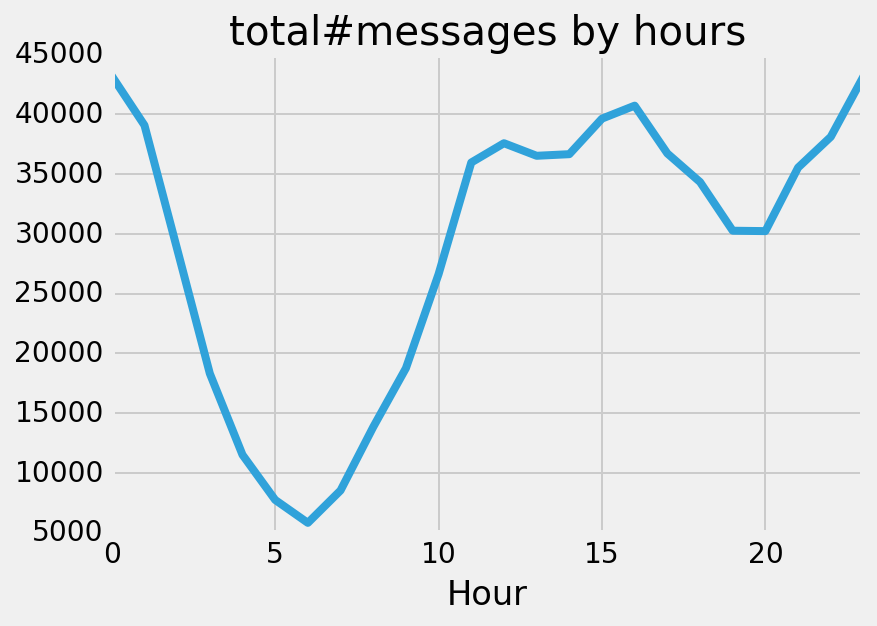

In [781]:
whole_df.groupby(['Hour']).count().message.plot(title = 'total#messages by hours')

In [940]:
whole_df.groupby(['Hour']).count().message

Hour
0     43213
1     39081
2     28726
3     18311
4     11506
5      7734
6      5814
7      8527
8     13835
9     18754
10    26629
11    35965
12    37579
13    36527
14    36662
15    39638
16    40722
17    36722
18    34333
19    30257
20    30224
21    35539
22    38113
23    43165
Name: message, dtype: int64

### More data organization.


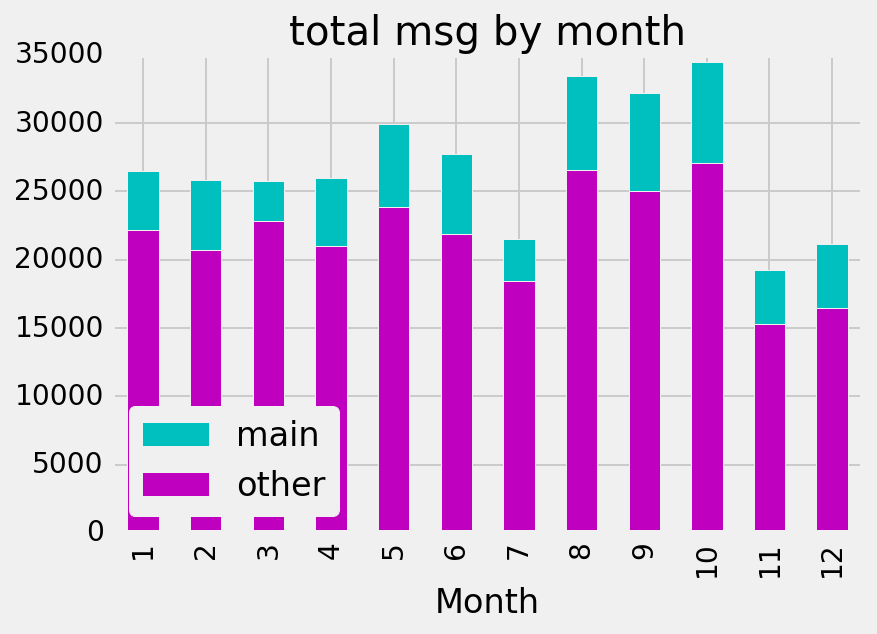

In [1028]:
#main_mean = main_user_df.groupby(['Month']).count().mean().message

main_user_df[main_user_df.Year != 2014].groupby(['Month']).count().message.plot(kind = 'bar', color = 'c', title = 'total msg by month')
others_df[others_df.Year != 2014].groupby(['Month']).count().message.plot(kind = 'bar', color = 'm')

#mean_line = ax.plot(12,main_mean, label='Mean', linestyle='--')
#ax.axvline(main_mean, lw=3, ls='dashed', color='blue')

plt.legend(['main', 'other'], loc = 3)

# I cannot conclude that the main user sends out more messages on average here. 
# since the other users' messages can be biased by 
# the number of people they talk to versus the main user. here's we're looking at one person vs many
# I can only say that the main user tends to send more messages than the accumulation of 
# all the people's messages that were sent to him


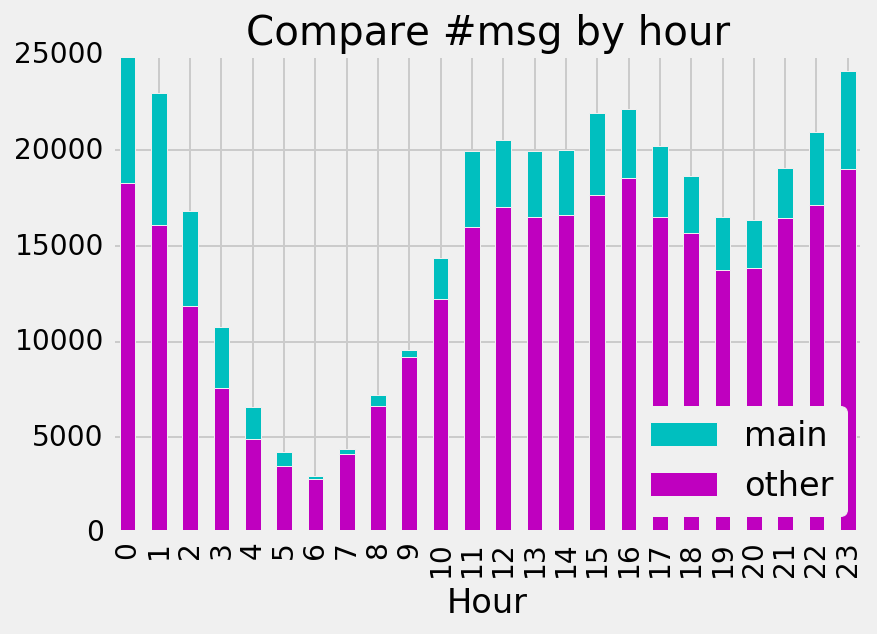

In [1029]:

main_user_df.groupby(['Hour']).count().message.plot(kind = 'bar', color = 'c', title = 'Compare #msg by hour')
others_df.groupby(['Hour']).count().message.plot(kind = 'bar', color = 'm')

plt.legend(['main', 'other'], loc = 4)

In [943]:
#creating another colume that has the # of words and another one with length of words(?)
whole_df['Length'] = whole_df.message.apply(len)


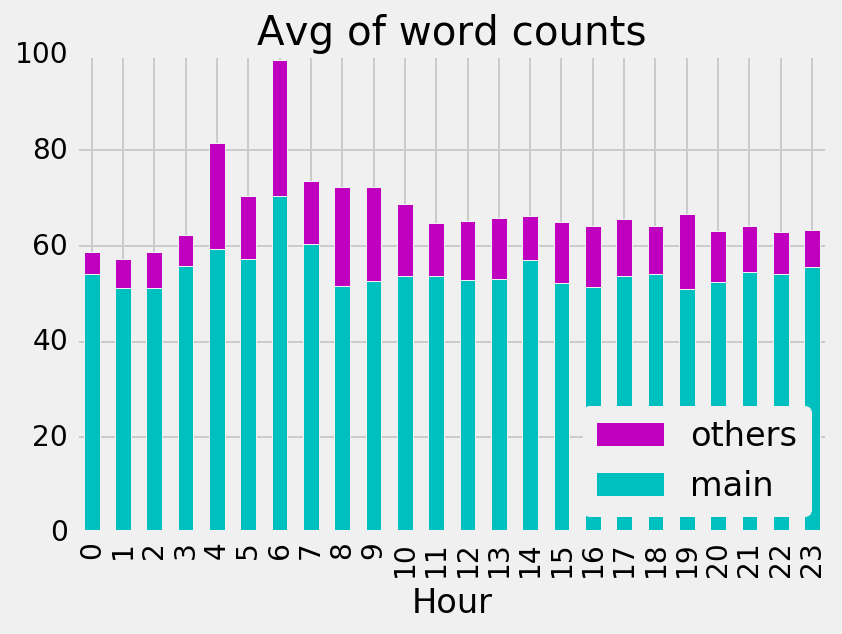

In [1034]:
# every hour, what is the average of # of words

others_df.groupby(['Hour']).Length.mean().plot(kind = 'bar', color = "m", title = "Avg of word counts")
main_user_df.groupby(['Hour']).Length.mean().plot(kind = "bar", color = "c")

plt.legend(['others', 'main'], loc = 4)

In [1035]:
print "Average# of messages sent by main user every month : ", main_user_df.groupby(['Month']).count().mean().message
print "Average# of messages sent by other users every month : ", others_df.groupby(['Month']).count().mean().message

#what are the implications of grouping all users into one category and count the average?

Average# of messages sent by main user every month :  32120.0
Average# of messages sent by other users every month :  26011.3333333


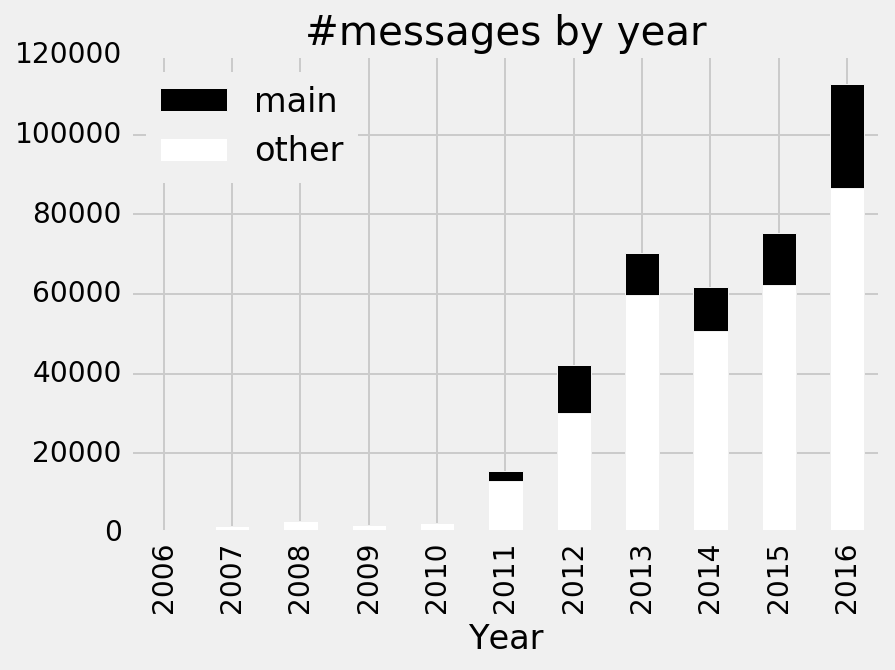

In [782]:
main_user_df.groupby(['Year']).count().message.plot(kind = 'bar', color = 'k', title = "#messages by year" )
others_df.groupby(['Year']).count().message.plot(kind = 'bar', color = 'w')
#others_df.groupby(['Year']).count().message.plot(kind = 'pie')

plt.legend(['main', 'other'], loc = 2)

#this graph didn't account the missing values for main_df. so the 6 black bars
# should be from 2011 to 2016
# then I changed some facebook email accouts to those belong to the main user
# now it looks nicer because previously it seemed like the main user didn't message before 2012 at all

In [953]:
print "main: "
print main_user_df.groupby(['Year']).count().message
print "\n-------------------------\n"
print "others: "
print others_df.groupby(['Year']).count().message
print "\n-------------------------\n"
print "differences:"
print 

# the main user doesn't start using messenger till 2011?!
# how is that possible? Perhaps, Facebook didn't even identify his name untill 2011
# so maybe the main user was identified as "random number"@facebook.com instead

main: 
Year
2006       446
2007      1580
2008      2140
2009      1237
2010      2212
2011     15489
2012     42271
2013     70207
2014     61743
2015     75346
2016    112769
Name: message, dtype: int64

-------------------------

others: 
Year
2006      350
2007     1753
2008     3015
2009     1971
2010     2441
2011    13172
2012    30148
2013    59807
2014    50759
2015    62217
2016    86503
Name: message, dtype: int64

-------------------------

differences:



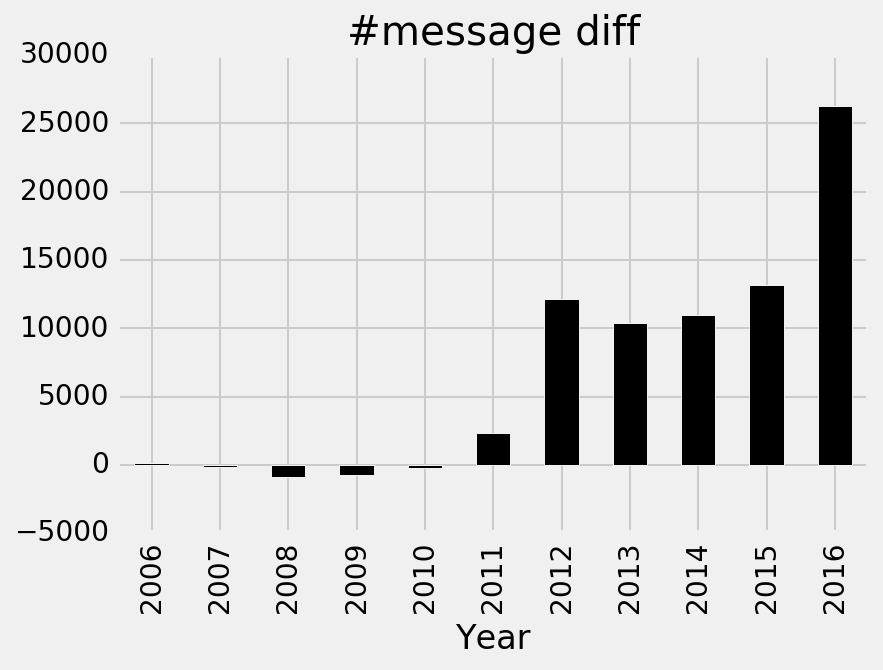

In [783]:
year_diff = main_user_df.groupby(['Year']).count().message - others_df.groupby(['Year']).count().message

year_diff.plot(kind = 'bar', title = '#message diff', color = 'k')

### Investigating how facebook named people before 2011

In [1004]:
# look at how many people whose name ended with "@facebook.com"
no_name_df = whole_df[whole_df.user.str.endswith('@facebook.com')]
no_name_df.info()
#22777 rows are no_names

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18040 entries, 2009-05-04 20:13:00 to 2016-10-24 12:23:00
Data columns (total 7 columns):
thread#    18040 non-null int64
user       18040 non-null object
message    18040 non-null object
Year       18040 non-null int32
Month      18040 non-null int32
Hour       18040 non-null int32
Length     18040 non-null int64
dtypes: int32(3), int64(2), object(2)
memory usage: 916.1+ KB


In [1005]:
others_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 312136 entries, 2012-02-17 16:51:00 to 2011-10-09 23:15:00
Data columns (total 7 columns):
thread#    312136 non-null int64
user       312136 non-null object
message    312136 non-null object
Year       312136 non-null int32
Month      312136 non-null int32
Hour       312136 non-null int32
Length     312136 non-null int64
dtypes: int32(3), int64(2), object(2)
memory usage: 15.5+ MB


In [1006]:
print ((18040.0/312136.0)*100),"% of the messages sent by other don't have a name"

5.77953199887 % of the messages sent by other don't have a name


In [1003]:
#average #ofmessages sent by others with no name
no_name_mean = no_name_df.groupby(['user']).count().mean().message
#average #ofmessages sent by others
other_mean = others_df.groupby(['user']).count().mean().message

print "the average of messages sent by those with no name is"
print no_name_mean
print "the average of messages sent by those with names is"
print other_mean

the average of messages sent by those with no name is
8.81289692233
the average of messages sent by those with names is
50.7951179821


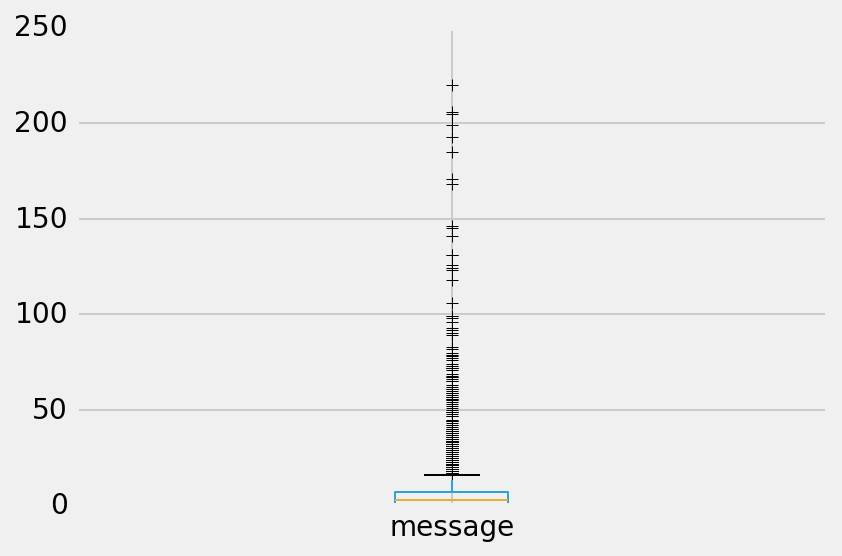

In [1001]:
no_name_df.groupby(['user']).count().message.plot(kind = "box")

In [1002]:
no_name_df.groupby(['user']).count().sort('message', ascending = False)[:10]
#1160383903@facebook.com --> Kelly Kerry ChowChow
#100001281229599@facebook.com --> Alex K. Chen
# 1109894092@facebook.com --> ben from tea with strangers
# 1329091068@facebook.com --> Frances Soong

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,thread#,message,Year,Month,Hour,Length
user,,,,,,
504366797@facebook.com,220,220,220,220,220,220
1473030364@facebook.com,206,206,206,206,206,206
1027740087@facebook.com,205,205,205,205,205,205
1065870469@facebook.com,199,199,199,199,199,199
808448775@facebook.com,193,193,193,193,193,193
1012060377@facebook.com,185,185,185,185,185,185
502469997@facebook.com,171,171,171,171,171,171
1562640087@facebook.com,168,168,168,168,168,168
698365910@facebook.com,146,146,146,146,146,146


### Too many erros, for future reference, just copy&paste the id to "https://www.facebook.com/profile.php?id=" to solve it

## Splitting into group vs private chat

In [936]:
# Creating a list of tuples identifying private or group conversations
pri_gro = [(ind,'private') if len(uni)==2 and "Main_User" in uni else (ind,'group/other')
 for ind,uni in enumerate(whole_df2.groupby(['thread#']).user.unique())]
    

In [937]:
style_df = pd.DataFrame(pri_gro, columns=['thread#', 'conco_style'])

In [ ]:
whole_df3 = pd.merge(whole_df2, style_df, on = 'thread#', how = 'left')

In [ ]:
private_df = whole_df4[whole_df4.convo_style == 'private']

In [ ]:
group_other_df = whole_df4[whole_df4.convo_style == 'group/other']